## Hart Algorithm Example

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = (13, 6)

In [3]:
import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation
from nilmtk.utils import print_dict
from nilmtk.metrics import f1_score

## Import Data from HDF file

In [4]:
data = DataSet('/data/redd.h5')
print('Loaded', len(data.buildings), 'buildings')

Loaded 6 buildings


## Loading data for Building 1

In [5]:
elec = data.buildings[1].elec

In [6]:
elec.get_timeframe()

TimeFrame(start='2011-04-18 09:22:09-04:00', end='2011-05-24 15:57:02-04:00', empty=False)

## Set a window

In [7]:
data.set_window(start='2011-04-20',end='2011-04-24')
elec_1 = data.buildings[1].elec

## Mains and Submeters Data

In [8]:
mains=elec_1.mains()
submeters=elec_1.submeters()

In [9]:
mains.available_ac_types('power')

['apparent']

In [10]:
submeters.available_ac_types('power')

['active']

## Running HART_85

In [11]:
from nilmtk.disaggregate.hart_85 import Hart85
h = Hart85()

#### Please set columns accordingly 
#### For REDD, since mains is 'Apparent Power'
#### For IAWE, you may set columns to columns= [('power','active')] or to columns= [('power','active'),('power','reactive')]


## Train the model

In [12]:
h.train(mains,columns=[('power','apparent')])

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


## Save Model using export_model

In [13]:
#h.export_model('model.pickle')

## Import model after saving

In [14]:
#h.import_model('model.pickle')

In [15]:
output = HDFDataStore('output.h5', 'w')
df=h.disaggregate(mains, output)

Loading data for meter ElecMeterID(instance=1, building=1, dataset='REDD')     

c:\nilmtk\nilmtk\metergroup.py:935: UserWarning: As a quick implementation we only get Good Sections from the first meter in the meter group.  We should really return the intersection of the good sections for all meters.  This will be fixed...
  warnings.warn("As a quick implementation we only get Good Sections from"


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for th

In [16]:
# Uncomment it for closing the Output HDFDataStore
# output.close()

## Returned Disaggregated Dataframe

In [17]:
df.tail()

,0,1,2
2011-04-23 23:55:00-04:00,209,0,0
2011-04-23 23:56:00-04:00,209,0,0
2011-04-23 23:57:00-04:00,209,0,0
2011-04-23 23:58:00-04:00,209,0,0
2011-04-23 23:59:00-04:00,0,0,0


## Since Hart is unsupervised, Find best matched appliances to disaggregated output.

In [18]:
h.best_matched_appliance(submeters,df)

Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Best Matched Pair is (0, ElecMeterID(instance=5, building=1, dataset='REDD'))
Best Matched Pair is (1, ElecMeterID(instance=6, building=1, dataset='REDD'))
Best Matched Pair is (2, MeterGroupID(meters=(ElecMeterID(instance=10, building=1, dataset='REDD'), ElecMeterID(instance=20, building=1, dataset='REDD'))))


## So it shows column 0's appliance best matches with Fridge, 1-> dish washer, 2-> washer dryer

In [19]:
elec  

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='REDD', site_meter, appliances=[])
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
  ElecMeter(instance=7, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=12, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=13, building=1, dataset='REDD', appliances=[Appliance(type='electric 

## Comparing for Fridge

In [20]:
# First we need to take intersection of indices of dataframes of fridge and predicted (Inner Join)
df_fridge = next(elec_1['fridge', 1].load())
merged_df = pd.merge(df[0], df_fridge, left_index=True, right_index=True)

C:\Users\meira\.conda\envs\nilmtk-env\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [21]:
merged_df.head()

,0,"(power, active)"
2011-04-22 22:49:00-04:00,0,6.0
2011-04-22 22:54:00-04:00,0,7.0
2011-04-22 22:55:00-04:00,0,7.0
2011-04-22 23:00:00-04:00,0,7.0
2011-04-22 23:01:00-04:00,0,6.0


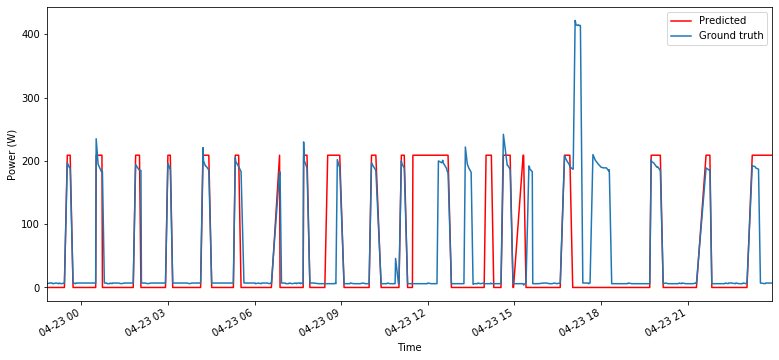

In [22]:
merged_df[0].plot(c='r')
merged_df['power', 'active'].plot()
plt.legend(["Predicted", "Ground truth"]);
plt.ylabel("Power (W)")
plt.xlabel("Time");

## Comparing for  Washer Dryer

In [23]:
df_dish_washer = next(elec_1['washer dryer', 1].load())
merged_df = pd.merge(df[2], df_fridge, left_index=True, right_index=True)

Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


C:\Users\meira\.conda\envs\nilmtk-env\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [24]:
merged_df.head()

,2,"(power, active)"
2011-04-22 22:49:00-04:00,0,6.0
2011-04-22 22:54:00-04:00,0,7.0
2011-04-22 22:55:00-04:00,0,7.0
2011-04-22 23:00:00-04:00,0,7.0
2011-04-22 23:01:00-04:00,0,6.0


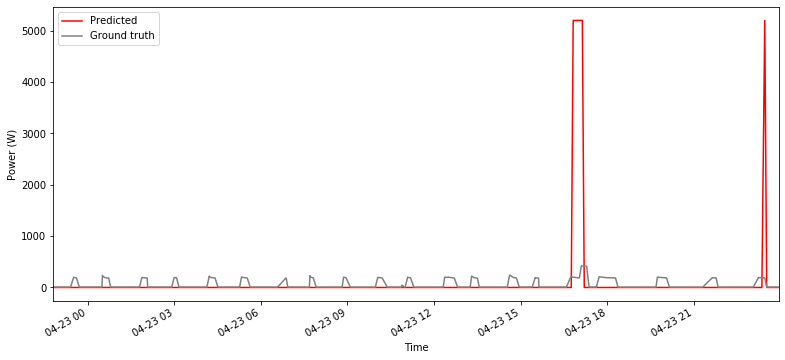

In [26]:
ax1 = merged_df[2].plot(c='r')
ax2 = merged_df['power', 'active'].plot(c='grey')
ax1.legend(["Predicted", "Ground truth"])
plt.ylabel("Power (W)")
plt.xlabel("Time");